# Reto 1

Grupo: GITan@s

Miembros:
- Andrea Carballo Torres
- Laura Fernández Galindo
- Luis Alberto López Álvarez
- Álvaro de Rojas Maraver
- Patricia Ortuño Otero
- Pablo Rubio Noguera

# Common imports and functions

In [2]:
# General import and load data
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import warnings

# Downsampling
from sklearn.utils import resample

# Training and test spliting
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Estimators
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# TPOT
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# Evaluation
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Optimization
from sklearn.model_selection import GridSearchCV

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

df = pd.read_csv('/kaggle/input/loan-approval-prediction-pennsylvania/train.csv')
df_old = pd.read_csv('/kaggle/input/train-antiguo/train.csv')

df = pd.concat([df,df_old]).drop_duplicates().reset_index(drop=True)

dfnolabel = pd.read_csv('/kaggle/input/loan-approval-prediction-pennsylvania/test_nolabel.csv')

# if matplotlib is not set inline, you will not see plots
#alternatives auto gtk gtk2 inline osx qt qt5 wx tk
#%matplotlib auto
#%matplotlib qt
%matplotlib inline

La función **print_evaluation_metrics** se utiliza para mostrar la accuracy, la matriz de confusión y un report sobre las métricas de precisión, recall y f1-score sobre los datos predichos y esperados de un sistema.

In [3]:
def print_evaluation_metrics(predicted, expected):
    # Compute accuracy score
    accuracy = metrics.accuracy_score(expected, predicted)
    
    # Compute confusion matrix
    conf_matrix = metrics.confusion_matrix(expected, predicted)

    # Compute classification report
    class_report = classification_report(expected, predicted)

    # Print accuracy score
    print("Accuracy Score:")
    print("{:.5%}".format(accuracy))
    print("\n")

    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\n")

    # Print classification report
    print("Classification Report:")
    print(class_report)

La función **build_array** se utiliza para obtener una matriz que represente los posibles valores de vecinos para encontrar los mejores hiperparámetros para kNN.

Se escogen utilizando la regla de la raíz cuadrada que se explica a continuación. La regla de la raíz cuadrada (K=sqrt(N)) se utiliza a menudo como una guía rápida para elegir un valor de K cuando no hay otra información disponible. Pero en algunos casos, puede ser necesario ajustar K para mejorar el rendimiento del modelo en el conjunto de datos específico. 

En general, se recomienda probar diferentes valores de K y seleccionar aquel que brinde el mejor rendimiento en el conjunto de datos en cuestión. Cuando se trata de un problema de dos clases, es mejor elegir un valor impar para K. De lo contrario, puede surgir un escenario en el que el número de vecinos en cada clase sea el mismo. Además, el valor de K no debe ser un múltiplo del número de clases presentes.

Esta función por tanto construye una matriz de posibles valores IMPARES y NO MÚLTIPLOS de la cantidad de clases del valor a predecir, en torno a sqrt(N), siendo N el número total de muestras juntando ambas clases (0 y 1).

In [4]:
def build_array(value_counts):
    total = value_counts.sum()
    
    # Compute the square root of the total
    sqrt_total = int(np.sqrt(total))

    # Build an array of 13 odd integers centered around the square root
    odd_array = np.arange(sqrt_total-12, sqrt_total+13, 2)
    odd_array = odd_array[odd_array > 0]
    odd_array = odd_array[odd_array <= total]
    return odd_array

# Clean data

## Visualize data

In [5]:
df.head()

,id,LoanNr_ChkDgt,Name,City,State,Bank,BankState,ApprovalDate,ApprovalFY,NoEmp,...,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,Accept
0,2fa57387ae1,6213754009,SETANTA SETTERS,PITTSBURGH,PA,CITIZENS BANK NATL ASSOC,MA,1-Apr-03,2003,1,...,1,2,1,1,Y,N,30-Jun-03,"$5,440.00",$0.00,1
1,a66f9849d7f,1751224008,DURACLEAN BY SEITZER,MONTOURSVILLE,PA,MANUFACTURERS & TRADERS TR CO,NY,19-Dec-97,1998,20,...,0,0,25850,0,N,Y,28-Feb-98,"$33,800.00",$0.00,1
2,fb6a6d89487,6979444003,PC HAINES WALL & CEILING CONTR,SALUNGA,PA,CITIZENS BANK NATL ASSOC,RI,1-Dec-03,2004,9,...,0,9,1,2,Y,N,29-Feb-04,"$156,599.00",$0.00,1
3,0ac44b54067,5825754005,LESLIE A LANDIS,YORK,PA,MANUFACTURERS & TRADERS TR CO,MD,31-Oct-02,2003,3,...,2,5,1,1,0,N,31-Jan-03,"$40,000.00",$0.00,1
4,3a5ff625fa3,8989333001,"MAILBOXES, ETC.",PHILADELPHIA,PA,NEWTEK SMALL BUS. FINANCE INC.,NY,7-Feb-96,1996,3,...,0,0,50564,0,N,Y,31-Oct-96,"$100,000.00",$0.00,1


## Study nullable and unique data

In [6]:
# Check there are not missing values
print('----------------------------- Null data -----------------------------\n')
print('Null data:\n', df.isnull().any())
print('\n')

# Check quantity of unique data
print('----------------------------- Unique values -----------------------------\n')
print('Total values: ', df['Accept'].value_counts().sum())
print('\n')
print('Quantity of unique values of [id]: ', len(df.id.unique()))
print('Quantity of unique values of [LoanNr_ChkDgt]: ', len(df.LoanNr_ChkDgt.unique()))
print('Quantity of unique values of [Name]: ', len(df.Name.unique()))
print('Quantity of unique values of [City]: ', len(df.City.unique()))
print('Quantity of unique values of [State]: ', len(df.State.unique()))
print('Quantity of unique values of [Bank]: ', len(df.Bank.unique()))
print('Quantity of unique values of [BankState]: ', len(df.BankState.unique()))
print('Quantity of unique values of [ApprovalDate]: ', len(df.ApprovalDate.unique()))
print('Quantity of unique values of [ApprovalFY]: ', len(df.ApprovalFY.unique()))
print('Quantity of unique values of [NoEmp]: ', len(df.NoEmp.unique()))
print('Quantity of unique values of [NewExist]: ', len(df.NewExist.unique()))
print('Quantity of unique values of [CreateJob]: ', len(df.CreateJob.unique()))
print('Quantity of unique values of [RetainedJob]: ', len(df.RetainedJob.unique()))
print('Quantity of unique values of [FranchiseCode]: ', len(df.FranchiseCode.unique()))
print('Quantity of unique values of [UrbanRural]: ', len(df.UrbanRural.unique()))
print('Quantity of unique values of [RevLineCr]: ', len(df.RevLineCr.unique()))
print('Quantity of unique values of [LowDoc]: ', len(df.LowDoc.unique()))
print('Quantity of unique values of [DisbursementDate]: ', len(df.DisbursementDate.unique()))
print('Quantity of unique values of [DisbursementGross]: ', len(df.DisbursementGross.unique()))
print('Quantity of unique values of [BalanceGross]: ', len(df.BalanceGross.unique()))
print('\n')

# Check quantity of missing values
print('----------------------------- Missing values -----------------------------\n')
print('Total values: ', df['Accept'].value_counts().sum())
print('\n')
print('Quantity of missing values of [id]: ', df.id.isna().sum())
print('Quantity of missing values of [LoanNr_ChkDgt]: ', df.LoanNr_ChkDgt.isna().sum())
print('Quantity of missing values of [Name]: ', df.Name.isna().sum())
print('Quantity of missing values of [City]: ', df.City.isna().sum())
print('Quantity of missing values of [State]: ', df.State.isna().sum())
print('Quantity of missing values of [Bank]: ', df.Bank.isna().sum())
print('Quantity of missing values of [BankState]: ', df.BankState.isna().sum())
print('Quantity of missing values of [ApprovalDate]: ', df.ApprovalDate.isna().sum())
print('Quantity of missing values of [ApprovalFY]: ', df.ApprovalFY.isna().sum())
print('Quantity of missing values of [NoEmp]: ', df.NoEmp.isna().sum())
print('Quantity of missing values of [NewExist]: ', df.NewExist.isna().sum())
print('Quantity of missing values of [CreateJob]: ', df.CreateJob.isna().sum())
print('Quantity of missing values of [RetainedJob]: ', df.RetainedJob.isna().sum())
print('Quantity of missing values of [FranchiseCode]: ', df.FranchiseCode.isna().sum())
print('Quantity of missing values of [UrbanRural]: ', df.UrbanRural.isna().sum())
print('Quantity of missing values of [RevLineCr]: ', df.RevLineCr.isna().sum())
print('Quantity of missing values of [LowDoc]: ', df.LowDoc.isna().sum())
print('Quantity of missing values of [DisbursementDate]: ', df.DisbursementDate.isna().sum())
print('Quantity of missing values of [DisbursementGross]: ', df.DisbursementGross.isna().sum())
print('Quantity of missing values of [BalanceGross]: ', df.BalanceGross.isna().sum())
print('\n')

# Check unique data
print('----------------------------- Unique values -----------------------------\n')
print('Possible unique values of [LowDoc]: ', df['LowDoc'].unique())
print('\n')
print('Possible unique values of [RevLineCr]: ', df['RevLineCr'].unique())
print('\n')
print('Possible unique values of [ApprovalFY]: ', df['ApprovalFY'].unique())
print('\n')
print('Possible unique values of [Bank]: ', df['Bank'].nunique())

----------------------------- Null data -----------------------------

Null data:
 id                   False
LoanNr_ChkDgt        False
Name                  True
City                 False
State                False
Bank                  True
BankState             True
ApprovalDate         False
ApprovalFY           False
NoEmp                False
NewExist              True
CreateJob            False
RetainedJob          False
FranchiseCode        False
UrbanRural           False
RevLineCr             True
LowDoc                True
DisbursementDate      True
DisbursementGross    False
BalanceGross         False
Accept               False
dtype: bool


----------------------------- Unique values -----------------------------

Total values:  65004


Quantity of unique values of [id]:  65004
Quantity of unique values of [LoanNr_ChkDgt]:  65004
Quantity of unique values of [Name]:  58787
Quantity of unique values of [City]:  4825
Quantity of unique values of [State]:  2
Quantity of uni

## Modify data based on the information each column provides

In [7]:
# Drop any columns that has as many unique values as there are total values in the dataset
columns_to_drop = [col for col in df.columns if len(df[col].unique()) == df['Accept'].value_counts().sum()]
print("Columns to be dropped: ", columns_to_drop)
df = df.drop(columns_to_drop, axis=1)

Columns to be dropped:  ['id', 'LoanNr_ChkDgt']


In [8]:
df['Name'] = df['Name'].fillna('ROCKFORD FEDERIC S.A')
df['Bank'] = df['Bank'].fillna('STATE OF HUDSON')
df['BankState'] = df['BankState'].fillna('NY')
df['NewExist'] = df['NewExist'].fillna(1)
df['RevLineCr'] = df['RevLineCr'].fillna('N')
df['LowDoc'] = df['LowDoc'].fillna('N')
df['DisbursementDate'] = df['DisbursementDate'].fillna('26-Dec-21')

df.loc[df["RevLineCr"] != "Y", "RevLineCr"] = 0
df.loc[df["RevLineCr"] == "Y", "RevLineCr"] = 1

df.loc[df["LowDoc"] != "Y", "LowDoc"] = 0
df.loc[df["LowDoc"] == "Y", "LowDoc"] = 1

In [9]:
# Check if all null data was erased
print('----------------------------- Null data -----------------------------\n')
print('Null data:\n', df.isnull().sum())
print('\n')

----------------------------- Null data -----------------------------

Null data:
 Name                 0
City                 0
State                0
Bank                 0
BankState            0
ApprovalDate         0
ApprovalFY           0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementDate     0
DisbursementGross    0
BalanceGross         0
Accept               0
dtype: int64




In [10]:
# Check data types
print('----------------------------- Data types -----------------------------\n')
df.dtypes

----------------------------- Data types -----------------------------



Name                  object
City                  object
State                 object
Bank                  object
BankState             object
ApprovalDate          object
ApprovalFY            object
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
Accept                 int64
dtype: object

In [11]:
# If it has a Franchise Code, then it will take a value of 1. If it didn't, a value of 0.
df['ApprovalFY']=df['ApprovalFY'].astype(str).str.extract('(\d+)').astype(int)

df['ApprovalDate'] = pd.to_datetime(df.ApprovalDate)
df['DisbursementDate'] = pd.to_datetime(df.DisbursementDate)

df.loc[(df['FranchiseCode'] == 1), 'FranchiseCode'] = 0
df.loc[(df['FranchiseCode'] != 0) & (df['FranchiseCode'] != 1), 'FranchiseCode'] = 1
df['FranchiseCode'] = df['FranchiseCode'].astype(np.int64)

In [12]:
# DisbursementGross: we associate a new numeric value according to the range in which the data is located.
def convertir_a_int(x):
    return int(float(x.replace('$', '').replace(' ', '').replace(',', '')))
df['DisbursementGross'] = df['DisbursementGross'].apply(convertir_a_int)

In [13]:
# Divide each DisbursementGross into ranges depending on the price

df['DisbursementRange'] = df['DisbursementGross']
df.loc[df['DisbursementGross'] >= 155000, 'DisbursementRange'] = int(0)
df.loc[(df['DisbursementGross'] < 155000) & (df['DisbursementGross'] >= 75000), 'DisbursementRange'] = int(1)
df.loc[(df['DisbursementGross'] < 75000) & (df['DisbursementGross'] >= 35000), 'DisbursementRange'] = int(2)
df.loc[df['DisbursementGross'] < 35000, 'DisbursementRange'] = int(3)

# Divide each ApprovalDate into groups of 3 months

df['ApprovalDateRange'] = df['ApprovalDate'].dt.month
df.loc[(df['ApprovalDate'].dt.month <= 3) & (df['ApprovalDate'].dt.month >= 1), 'ApprovalDateRange'] = int(0)
df.loc[(df['ApprovalDate'].dt.month <= 6) & (df['ApprovalDate'].dt.month >= 4), 'ApprovalDateRange'] = int(1)
df.loc[(df['ApprovalDate'].dt.month <= 9) & (df['ApprovalDate'].dt.month >= 7), 'ApprovalDateRange'] = int(2)
df.loc[df['ApprovalDate'].dt.month > 9, 'ApprovalDateRange'] = int(3)

# Divide each DisbursementDate into groupf of 3 months

df['DisbursementDateRange'] = df['DisbursementDate'].dt.month
df.loc[(df['DisbursementDate'].dt.month <= 3) & (df['DisbursementDate'].dt.month >= 1), 'DisbursementDateRange'] = int(0)
df.loc[(df['DisbursementDate'].dt.month <= 6) & (df['DisbursementDate'].dt.month >= 4), 'DisbursementDateRange'] = int(1)
df.loc[(df['DisbursementDate'].dt.month <= 9) & (df['DisbursementDate'].dt.month >= 7), 'DisbursementDateRange'] = int(2)
df.loc[df['DisbursementDate'].dt.month > 9, 'DisbursementDateRange'] = int(3)

In [14]:
indexBankState = df["BankState"].unique()

for i in range (0, df['BankState'].nunique()):
    df.loc[df["BankState"] == indexBankState[i] , "BankState"] = i

indexBank = df["Bank"].unique()
for i in range (0, df['Bank'].nunique()):
    df.loc[df["Bank"] == indexBank[i] , "Bank"] = i

In [15]:
# Erase unnecessary columns (APPROVALDATE, DISBURSEMENTGROSS DISBURSEMENTGROSSINT DISBURSEMENTDATE ETC.)
df = df.drop(['ApprovalDate', 'DisbursementDate', 'DisbursementGross', 'State', 'BalanceGross'], axis=1)

In [16]:
df['LowDoc'] = df['LowDoc'].astype(int, errors = 'raise')
df['Bank'] = df['Bank'].astype(int, errors = 'raise')
df['RevLineCr'] = df['RevLineCr'].astype(int, errors = 'raise')
df['ApprovalFY'] = df['ApprovalFY'].astype(int, errors = 'raise')
df['NewExist'] = df['NewExist'].astype(int, errors = 'raise')
df['BankState'] = df['BankState'].astype(int, errors = 'raise')
df['Name'] = df['Name'].astype(str, errors = 'raise')
df['City'] = df['City'].astype(str, errors = 'raise')

In [ ]:
dfnolabel['Name'] = dfnolabel['Name'].fillna('ROCKFORD FEDERIC S.A')
dfnolabel['Bank'] = dfnolabel['Bank'].fillna('STATE OF HUDSON')
dfnolabel['BankState'] = dfnolabel['BankState'].fillna('NY')
dfnolabel['NewExist'] = dfnolabel['NewExist'].fillna(1)
dfnolabel['RevLineCr'] = dfnolabel['RevLineCr'].fillna('N')
dfnolabel['LowDoc'] = dfnolabel['LowDoc'].fillna('N')
dfnolabel['DisbursementDate'] = dfnolabel['DisbursementDate'].fillna('26-Dec-21')

dfnolabel.loc[dfnolabel["RevLineCr"] != "Y", "RevLineCr"] = 0
dfnolabel.loc[dfnolabel["RevLineCr"] == "Y", "RevLineCr"] = 1

dfnolabel.loc[dfnolabel["LowDoc"] != "Y", "LowDoc"] = 0
dfnolabel.loc[dfnolabel["LowDoc"] == "Y", "LowDoc"] = 1


dfnolabel['ApprovalFY']=dfnolabel['ApprovalFY'].astype(str).str.extract('(\d+)').astype(int)

dfnolabel['ApprovalDate'] = pd.to_datetime(dfnolabel.ApprovalDate)
dfnolabel['DisbursementDate'] = pd.to_datetime(dfnolabel.DisbursementDate)

dfnolabel.loc[(dfnolabel['FranchiseCode'] == 1), 'FranchiseCode'] = 0
dfnolabel.loc[(dfnolabel['FranchiseCode'] != 0) & (dfnolabel['FranchiseCode'] != 1), 'FranchiseCode'] = 1
dfnolabel['FranchiseCode'] = dfnolabel['FranchiseCode'].astype(np.int64)

#DisbursementGross: we associate a new numeric value according to the range in which the data is located.
def convertir_a_int(x):
    return int(float(x.replace('$', '').replace(' ', '').replace(',', '')))
dfnolabel['DisbursementGross'] = dfnolabel['DisbursementGross'].apply(convertir_a_int)

# Puede ser que haya que añadir más grupos según la distribución que haya (Se agrupan dinero y 2 tipos de fechas)

dfnolabel['DisbursementRange'] = dfnolabel['DisbursementGross']
dfnolabel.loc[dfnolabel['DisbursementGross'] >= 155000, 'DisbursementRange'] = int(0)
dfnolabel.loc[(dfnolabel['DisbursementGross'] < 155000) & (dfnolabel['DisbursementGross'] >= 75000), 'DisbursementRange'] = int(1)
dfnolabel.loc[(dfnolabel['DisbursementGross'] < 75000) & (dfnolabel['DisbursementGross'] >= 35000), 'DisbursementRange'] = int(2)
dfnolabel.loc[dfnolabel['DisbursementGross'] < 35000, 'DisbursementRange'] = int(3)

dfnolabel['ApprovalDateRange'] = dfnolabel['ApprovalDate'].dt.month
dfnolabel.loc[(dfnolabel['ApprovalDate'].dt.month <= 3) & (dfnolabel['ApprovalDate'].dt.month >= 1), 'ApprovalDateRange'] = int(0)
dfnolabel.loc[(dfnolabel['ApprovalDate'].dt.month <= 6) & (dfnolabel['ApprovalDate'].dt.month >= 4), 'ApprovalDateRange'] = int(1)
dfnolabel.loc[(dfnolabel['ApprovalDate'].dt.month <= 9) & (dfnolabel['ApprovalDate'].dt.month >= 7), 'ApprovalDateRange'] = int(2)
dfnolabel.loc[dfnolabel['ApprovalDate'].dt.month > 9, 'ApprovalDateRange'] = int(3)

dfnolabel['DisbursementDateRange'] = dfnolabel['DisbursementDate'].dt.month
dfnolabel.loc[(dfnolabel['DisbursementDate'].dt.month <= 3) & (dfnolabel['DisbursementDate'].dt.month >= 1), 'DisbursementDateRange'] = int(0)
dfnolabel.loc[(dfnolabel['DisbursementDate'].dt.month <= 6) & (dfnolabel['DisbursementDate'].dt.month >= 4), 'DisbursementDateRange'] = int(1)
dfnolabel.loc[(dfnolabel['DisbursementDate'].dt.month <= 9) & (dfnolabel['DisbursementDate'].dt.month >= 7), 'DisbursementDateRange'] = int(2)
dfnolabel.loc[dfnolabel['DisbursementDate'].dt.month > 9, 'DisbursementDateRange'] = int(3)

indexBankState = dfnolabel["BankState"].unique()

for i in range (0, dfnolabel['BankState'].nunique()):
    dfnolabel.loc[dfnolabel["BankState"] == indexBankState[i] , "BankState"] = i

indexBank = dfnolabel["Bank"].unique()
for i in range (0, dfnolabel['Bank'].nunique()):
    dfnolabel.loc[dfnolabel["Bank"] == indexBank[i] , "Bank"] = i
    
# Convertimos los tipos a enteros
# Eliminamos campos auxiliares (APPROVALDATE, DISBURSEMENTGROSS DISBURSEMENTGROSSINT DISBURSEMENTDATE ETC.)
dfnolabel = dfnolabel.drop(['ApprovalDate', 'DisbursementDate', 'DisbursementGross', 'State', 'BalanceGross'], axis=1)

dfnolabel['LowDoc'] = dfnolabel['LowDoc'].astype(int, errors = 'raise')
dfnolabel['Bank'] = dfnolabel['Bank'].astype(int, errors = 'raise')
dfnolabel['RevLineCr'] = dfnolabel['RevLineCr'].astype(int, errors = 'raise')
dfnolabel['ApprovalFY'] = dfnolabel['ApprovalFY'].astype(int, errors = 'raise')
dfnolabel['NewExist'] = dfnolabel['NewExist'].astype(int, errors = 'raise')
dfnolabel['BankState'] = dfnolabel['BankState'].astype(int, errors = 'raise')
dfnolabel['Name'] = dfnolabel['Name'].astype(str, errors = 'raise')
dfnolabel['City'] = dfnolabel['City'].astype(str, errors = 'raise')

## Look at the correlation between each column with Accept

In [17]:
# Check how many values there are for each class of the Acept column
print('----------------------------- Accept -----------------------------\n')
print('Accept values: \n', df['Accept'].value_counts())

----------------------------- Accept -----------------------------

Accept values: 
 1    52959
0    12045
Name: Accept, dtype: int64


Accept                   1.000000
ApprovalFY               0.181333
UrbanRural               0.133916
BankState                0.117004
RevLineCr                0.094688
DisbursementRange        0.094584
LowDoc                   0.090435
Bank                     0.086758
NoEmp                    0.019884
FranchiseCode            0.018363
NewExist                 0.013721
DisbursementDateRange    0.012215
RetainedJob              0.012077
CreateJob                0.011120
ApprovalDateRange        0.000312
Name: Accept, dtype: float64


<AxesSubplot:>

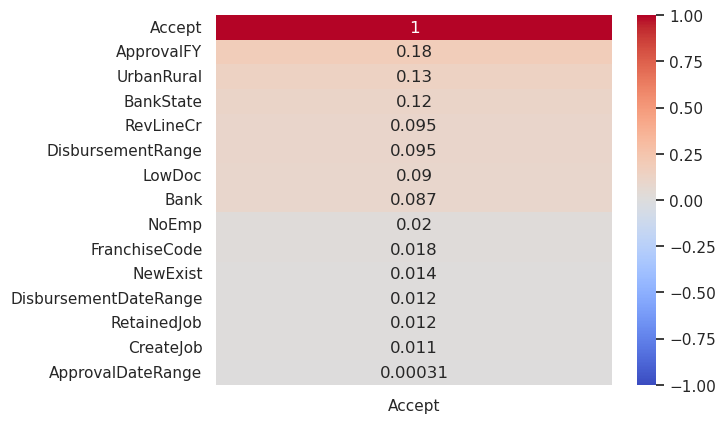

In [18]:
# Select the columns of interest
cols = df.columns.tolist()
cols.remove('Accept')

# Compute the correlation matrix with Accept
corr = df[cols + ["Accept"]].corr()

# Display the correlation coefficients for Accept
print(corr["Accept"].abs().sort_values(ascending=False))

# Create a heatmap
sns.heatmap(corr[["Accept"]].abs().sort_values(by=["Accept"], ascending=False),
            cmap="coolwarm", annot=True, vmin=-1, vmax=1, annot_kws={"size": 12})

Dentro de los campos con mayor correlación, vamos a comprobar si todos ellos aportan información relevante:

# Training

In [19]:
# Features of the model (Over 0.1 of correlation to Accept)
features = corr[abs(corr["Accept"]) > 0.09].index.tolist()
features.remove("Accept")
print(features)

# Transform dataframe in numpy arrays
X_train = df[features].values
y_train = df['Accept'].values

#X_test = dfnolabel[features].values
#y_test = dfnolabel['Accept'].values

# Test set will be the 25% taken randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

# Null accuracy

In [20]:
# Count number of samples per class
s_y_test = Series(y_test)

# Calculate null accuracy (binary classification coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

# Calculate null accuracy (multiclass classification)
s_y_test.value_counts().head(1) / len(y_test)

1    0.813858
dtype: float64

Fiarse únicamente de la exactitud no es buena práctica si el conjunto de datos no está balanceado, ya que no tiene en cuenta la distribución en clases. Se puede predecir la clase mayoritaria más comunmente por error, y obtener alta exactitud, pero que funcione erroneamente para la minoritaria. Para eso calculamos la null_accuraccy. A la vista de los resultados, es de 0.7997 (79.97%), es decir, en el conjunto de datos hay un 80% de datos de clase 1, por lo que si predijesemos siempre esta clase, acertaríamos un 80% de las veces.

Para que el modelo sea válido, la accuracy tendría que se mayor que la null_accuracy; como en este caso es muy elevada, es muy dificil que se cumpla esta condición y se va a realizar un balanceo del conjunto de datos a continuación.

# Downsampling

In [21]:
# Combine features and target variable into a single DataFrame
df_aux = pd.DataFrame(data=X_train, columns=features)
df_aux['Accept'] = y_train

# Separate majority and minority classes
df_majority = df_aux[df_aux.Accept==1]
df_minority = df_aux[df_aux.Accept==0]

# Downsample majority class
df_majority_downsampled = resample(df_majority,replace=False,n_samples=min(df_aux['Accept'].value_counts()),random_state=123)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled.Accept.value_counts()

# Transform dataframe in numpy arrays
X_balanced = df_downsampled[features].values
y_balanced = df_downsampled['Accept'].values

Ahora podemos comprobar si ha aumentado la correlación entre las columnas escogidas y Accept después del balanceo.

Accept               1.000000
ApprovalFY           0.233606
UrbanRural           0.186017
BankState            0.147001
DisbursementRange    0.129596
LowDoc               0.126712
RevLineCr            0.119693
Name: Accept, dtype: float64


<AxesSubplot:>

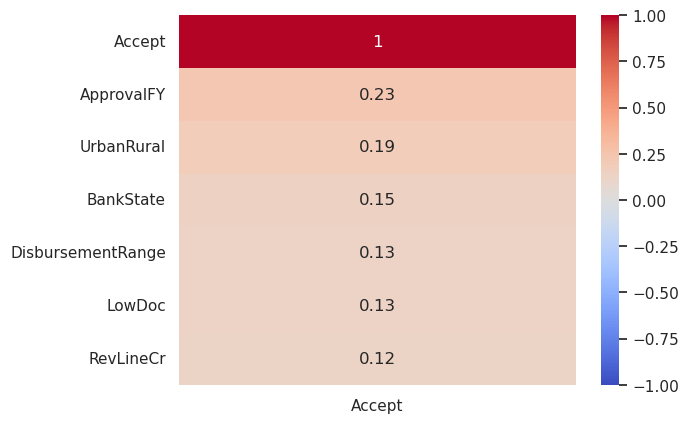

In [22]:
# Select the columns of interest
cols = df_downsampled.columns.tolist()
cols.remove('Accept')

# Compute the correlation matrix with Accept
corr = df_downsampled[cols + ["Accept"]].corr()

# Display the correlation coefficients for Accept
print(corr["Accept"].abs().sort_values(ascending=False))

# Create a heatmap
sns.heatmap(corr[["Accept"]].abs().sort_values(by=["Accept"], ascending=False),
            cmap="coolwarm", annot=True, vmin=-1, vmax=1, annot_kws={"size": 12})

Se puede apreciar como, en este caso, los resultados obtenidos son iguales tanto para el conjunto mayoritario como para el minoritario.

In [23]:
df_downsampled['Accept'].value_counts()

1    9020
0    9020
Name: Accept, dtype: int64

Una vez hemos llegado a este punto, ya tenemos todos los datos preprocesados y listos para ser entrenados utilizando el algoritmo asignado y los dos algoritmos de nuestra elección, basandonos en las pautas del enunciado.

* Como parte de la competición, es obligatorio para cada equipo emplear un algoritmo geométrico y un árbol de decisión. Por supuesto, el equipo debe usar además el "algoritmo secreto".

Los algoritmos escogidos como geométrico y árbol de decisión son, respectivamente, Logistic Regression y Random Forest. Además, el algoritmo asignado a nuestro equipo es el GaussianNB.

# Geometric Models

## Logistic Regression

En primer lugar, se ha escogido el algoritmo de Logistic Regression, debido a los buenos resultados obtenidos con este en las prácticas realizadas en clase; a continuación se ven los resultados obtenidos para el entrenamiento del modelo con este algoritmo.

In [32]:
from sklearn.metrics import f1_score, make_scorer 

# Filter warning messages
warnings.filterwarnings('ignore')

# Define the parameter grid to search
param_grid_LR = {'C': np.logspace(-3,3,7),
              'penalty': ['l1', 'l2', 'elasticnet'],
              'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag'],
              'l1_ratio': [0.5]}

# Create Logistic Regression model
model_LR = LogisticRegression()

# Perform grid search
f1 = make_scorer(f1_score)
grid_search_LR = GridSearchCV(model_LR, param_grid=param_grid_LR, cv=5, scoring=f1)
grid_search_LR.fit(X_balanced, y_balanced)

# Print the best hyperparameters and score
print("Best parameters: ", grid_search_LR.best_params_)
print("Best score: ", grid_search_LR.best_score_)

Best parameters:  {'C': 0.001, 'l1_ratio': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
Best score:  0.6655368613459979


Resultados: 1 intento: 65.72%
            2 intento: 67.42% (Eliminando feature LoanNr_ChkDgt)
            3 intento: 67.72% (Eliminando feature DisbursementRange)
            2 datasets.
            4 intento: 64.53% (Con los 2 dataset para entrenamiento)

In [25]:
# Create logistic regression model with best hyperparameters
model_LR = LogisticRegression(penalty=grid_search_LR.best_estimator_.penalty, 
                           l1_ratio=grid_search_LR.best_estimator_.l1_ratio, 
                           C=grid_search_LR.best_estimator_.C, 
                           solver=grid_search_LR.best_estimator_.solver)

# Predict
model_LR.fit(X_balanced, y_balanced)
predicted_LR = model_LR.predict(X_test)
expected_LR = y_test

# Metrics
print_evaluation_metrics(predicted_LR, expected_LR)

Accuracy Score:
59.81170%


Confusion Matrix:
[[2170  855]
 [5676 7550]]


Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.72      0.40      3025
           1       0.90      0.57      0.70     13226

    accuracy                           0.60     16251
   macro avg       0.59      0.64      0.55     16251
weighted avg       0.78      0.60      0.64     16251



Resultados: 1 intento: Accuracy: 59.81%. f1: 64%

## SVM

-Realizamos el modelado utilizando el algoritmo SVM. Para el kernel hemos utilizado el 'rbf', ya que era el escogido como mejor opción tras la realización de multiples pruebas, logrando así disminuir los tiempos de ejecución.

In [26]:
'''param_grid_SVM = {'C':[1,10,100],
                  'gamma':[0.1],
                  'kernel':['rbf']}

# Create SVM model
model_SVM = SVC()

# Perform grid search
grid_search_SVM = GridSearchCV(model_SVM, param_grid=param_grid_SVM, cv=5)
grid_search_SVM.fit(X_balanced, y_balanced)

# Print the best hyperparameters and score
print("Best parameters: ", grid_search_SVM.best_params_)
print("Best score: ", grid_search_SVM.best_score_)
'''

'param_grid_SVM = {\'C\':[1,10,100],\n                  \'gamma\':[0.1],\n                  \'kernel\':[\'rbf\']}\n\n# Create SVM model\nmodel_SVM = SVC()\n\n# Perform grid search\ngrid_search_SVM = GridSearchCV(model_SVM, param_grid=param_grid_SVM, cv=5)\ngrid_search_SVM.fit(X_balanced, y_balanced)\n\n# Print the best hyperparameters and score\nprint("Best parameters: ", grid_search_SVM.best_params_)\nprint("Best score: ", grid_search_SVM.best_score_)\n'

In [27]:
# Create SVM model
model_SVM = SVC(C=100,
                gamma=0.1,
                kernel='rbf')

# Predict with the model
model_SVM.fit(X_balanced, y_balanced)
predicted_SVM = model_SVM.predict(X_test)
expected_SVM = y_test

# Metrics
print_evaluation_metrics(predicted_SVM, expected_SVM)

Accuracy Score:
71.04794%


Confusion Matrix:
[[2123  902]
 [3803 9423]]


Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.70      0.47      3025
           1       0.91      0.71      0.80     13226

    accuracy                           0.71     16251
   macro avg       0.64      0.71      0.64     16251
weighted avg       0.81      0.71      0.74     16251



Resultados: 1 intento: 72,83% (Ya con los 4 features definitivos)
            2 intento: % (Con los 2 dataset para entrenamiento)

1 intento: Accuracy: 71.04%. f1: 74%

## KNN (k-Nearest Neighbours)

A continuación, se va a realizar el modelado con el algoritmo kNN. Se ha probado a utilizar diferentes métricas para los parámetros, probando la opción de minkovski pero eliminándola al no ser óptima. 

In [ ]:
# Define the parameter grid to search
value_counts = df_downsampled['Accept'].value_counts()
odd_array = build_array(value_counts)

param_grid_KNN = {'n_neighbors': odd_array,
                  'metric': ['euclidean','manhattan', 'chebyshev'],
                  'algorithm': ['brute'],
                  'leaf_size': [1,30]
}

# Create KNN model
model_KNN = KNeighborsClassifier(weights='distance')

# Perform grid search
grid_search_KNN = GridSearchCV(model_KNN, param_grid=param_grid_KNN, cv=5, verbose=1)
grid_search_KNN.fit(X_balanced, y_balanced)

# Print the best hyperparameters and score
print("Best parameters: ", grid_search_KNN.best_params_)
print("Best score: ", grid_search_KNN.best_score_)

Fitting 5 folds for each of 78 candidates, totalling 390 fits


Resultados: 1º intento: 58.68%
            2º intento: 72.25% (Quitando feature DisbursementRange y eliminando hiperparametros de prueba innecesarios)
            3º intento: 72.25% (Añadiendo p y leaf_size, por lo que se eliminan al no ser escogidos)
            4º intento: 72.58% (Aplicando la regla de la raiz y añadiendo el método de n_neighbors)
            5 intento: % (Con 2 datasets)

In [ ]:
# Create KNN model
model_KNN = KNeighborsClassifier(n_neighbors=grid_search_KNN.best_estimator_.n_neighbors,
                                metric=grid_search_KNN.best_estimator_.metric,
                                algorithm=grid_search_KNN.best_estimator_.algorithm,
                                leaf_size=grid_search_KNN.best_estimator_.leaf_size)

# Predict with the model
model_KNN.fit(X_balanced, y_balanced)
predicted_KNN = model_KNN.predict(X_test)
expected_KNN = y_test

# Metrics
print_evaluation_metrics(predicted_KNN, expected_KNN)

1 intento: Accuracy: 74%. f1: 76%
2 intento: Accuracy: %. f1: %

## Stacking

In [ ]:
model_SGD = SGDClassifier()

Cs = [0.0001,0.001,0.01,0.1,1,10]

param_grid_SGD = [{'alpha': Cs}]

grid_search_SGD = GridSearchCV(model_SGD, param_grid=param_grid_SGD, cv=5)

grid_search_SGD.fit(X_balanced, y_balanced)

print("Best parameters: ", grid_search_SGD.best_params_)

model_SGD = SGDClassifier(alpha=grid_search_SGD.best_estimator_.alpha)

In [31]:
models = [('lr', model_LR),('knn', model_KNN),('svm', model_SVM)]

'''S_Train, S_Test = stacking(models,x_train, y_train ,x_test, 
                           regression=False, 
                           mode='oof_pred_bag',
                           needs_proba=False,
                           save_dir=None,
                           metric= roc_auc_score,
                           n_folds=4,
                           stratified=True,
                           shuffle=True,
                           random_state=0,
                           verbose=2)
'''

sclf = StackingClassifier(estimators=models, final_estimator=SGDClassifier(alpha=0.0001))

params = {'stack_method': ['auto', 'predict_proba', 'decision_function', 'predict']}

grid = GridSearchCV(estimator=sclf, param_grid=params, cv=5)
grid.fit(X_balanced, y_balanced)

# Print the best hyperparameters and score
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)

KeyboardInterrupt: 

Se ha realizado un stacking con cada uno de los 3 modelos entrenados previamente para mejorar los resultados individuales obtenidos en el entrenamiento, que son los anteriores.
* Prueba 1: 72,94%

In [ ]:
# Create Stacking Model
model_SCLF = StackingClassifier(estimators=models,
                                final_estimator=model_SGD,
                                stack_method=grid.best_estimator_.stack_method)

# Predict with the model
model_SCLF.fit(X_balanced, y_balanced)
predicted_SCLF = model_SCLF.predict(X_test)
expected_SCLF = y_test

# Metrics
print_evaluation_metrics(predicted_SCLF, expected_SCLF)

# Secret Model: GaussianNB

**GaussianNB** es un algoritmo para clasificación supervisada, perteneciente al grupo de Naive Bayes. Clasifica según una probabilidad de pertenecer a una clase terminada.

Utilizando TPOT se han calculado los mejores hiperparámetros para construir el modelo de GaussianNB. Se utiliza un flujo de trabajo exported_pipeline que usa los siguientes elementos:

- MinMaxScaler(): escalar los datos de entrada a un rango determinado (0,1)
- StackingEstimator: es un componente que se utiliza para apilar varios estimadores juntos. En este caso, los dos estimadores apilados son el SGDClassifier y el GradientBoostingClassifier. Ambos son algoritmos de clasificación que se utilizan para predecir la clase de un conjunto de datos.
- SelectPercentile: seleccionar las características más importantes de los datos de entrada. En este caso se usa f_classif para seleccionar el 25% de las más importantes.

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

exported_pipeline = make_pipeline(
    MinMaxScaler(),
    StackingEstimator(estimator=SGDClassifier(alpha=0.0, 
                                              eta0=0.01, 
                                              fit_intercept=False, 
                                              l1_ratio=1.0, 
                                              learning_rate="invscaling", 
                                              loss="hinge", 
                                              penalty="elasticnet", 
                                              power_t=1.0
                                             )
                     ),
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.1, 
                                                            max_depth=3, 
                                                            max_features=0.8500000000000001, 
                                                            min_samples_leaf=16, 
                                                            min_samples_split=17, 
                                                            n_estimators=100, 
                                                            subsample=0.7500000000000001
                                                            )
                     ),
    SelectPercentile(score_func=f_classif, percentile=25),
    GaussianNB()
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 33)

exported_pipeline.fit(X_balanced, y_balanced)

predicted_GNB = exported_pipeline.predict(X_test)
expected_GNB = y_test

# Metrics
print_evaluation_metrics(predicted_GNB, expected_GNB)

# Árbol de Decisión: Random Forest

Se modifican las features que se introducen al modelo, ya que para este caso, es más conveniente pasarle 5 features que las 4 que se venían pasando anteriormente.

In [ ]:
# Features of the model
features = ['ApprovalFY', 'UrbanRural', 'BankState', 'RevLineCr', 'DisbursementRange']

# Transform dataframe in numpy arrays
X = df[features].values
y = df['Accept'].values

# Test set will be the 25% taken randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

In [ ]:
from sklearn.utils import resample

# Combine features and target variable into a single DataFrame
df_aux = pd.DataFrame(data=X_train, columns=features)
df_aux['Accept'] = y_train

# Separate majority and minority classes
df_majority = df_aux[df_aux.Accept==1]
df_minority = df_aux[df_aux.Accept==0]

# Downsample majority class
df_majority_downsampled = resample(df_majority,replace=False,n_samples=min(df_aux['Accept'].value_counts()),random_state=123)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled.Accept.value_counts()

# Transform dataframe in numpy arrays
X_balanced = df_downsampled[features].values
y_balanced = df_downsampled['Accept'].values

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Tune parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [2,4]

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
gs.fit(X_balanced, y_balanced)
scores = gs.score(X_test, y_test)
print(scores)

Resultados: 
* 1 intento: 73.39%
* 2 intento: 72.19%
* 3 intento: 72.81%

In [ ]:
model_RF = RandomForestClassifier(n_estimators=gs.best_estimator_.n_estimators,
                               max_depth=gs.best_estimator_.max_depth,
                               min_samples_split=gs.best_estimator_.min_samples_split,
                               bootstrap=gs.best_estimator_.bootstrap,
                               max_features=gs.best_estimator_.max_features,
                               min_samples_leaf=gs.best_estimator_.min_samples_leaf,
                               random_state=0)

In [ ]:
model_RF.fit(X_balanced, y_balanced)

predicted_RF = model_RF.predict(X_test)
expected_RF = y_test

# Accuracy
metrics.accuracy_score(y_test, predicted_RF)

In [ ]:
# Confusion matrix
print(metrics.confusion_matrix(expected_GNB, predicted_GNB))

# Report
print(classification_report(expected_GNB, predicted_GNB))

In [ ]:
x_nolabel = dfnolabel[features]
y_nolabel = model_SVM.predict(x_nolabel)
id = dfnolabel['id']

In [ ]:
dfsave = pd.DataFrame({'id': id, 'Accept': y_nolabel}, columns=["id", "Accept"])

'''# Seleccionar las primeras 3274 filas del DataFrame
df_new = dfsave.iloc[:3274]

print(df_new.iloc[109])

# Dividir la columna en dos filas usando la función split()
df_new[['id', 'Accept']] = df_new['id'].str.split(',', 1, expand=True)
'''
# Guardar el DataFrame modificado en un archivo CSV
dfsave.to_csv('submission.csv', index=False, header=True)

# Árbol de decisión de XGBClassifier

**XGBClassifier** es un algoritmo para clasificación supervisada, basado en árboles de decisión, que se utiliza para predecir una clase, en este caso Accept 0 o 1, para un conjunto de datos en función de varias características de entrada.

Se basa en la implementación de Extreme Gradient Boosting (XGBoost), que utiliza árboles de decisión y boosting para mejorar la precisión de las predicciones.

Se construyen múltiples modelos débiles en secuencia (árboles de decisión), centrados en los errores del modelo anterior. Se agregan en serie para mejorar la precisión y minimizar el error de clasificación.

Los parámetros óptimos de este modelo se han logrado utilizando TPOT con 5 generaciones y una población de 50.

In [ ]:
# Create XGBClassifier Model
model_XGB = XGBClassifier(learning_rate=0.1,
                          max_depth=9,
                          min_child_weight=8,
                          n_estimators=100,
                          n_jobs=1,
                          subsample=0.4,
                          verbosity=0
                         )

# Predict with the model
model_XGB.fit(X_balanced, y_balanced)
predicted_XGB = model_XGB.predict(X_test)
expected_XGB = y_test

# Metrics
print_evaluation_metrics(predicted_XGB, expected_XGB)

# Preparación Submission

In [ ]:
x_nolabel = dfnolabel[features]
y_nolabel = model_SVM.predict(x_nolabel)
id = dfnolabel['id']

In [ ]:
dfsave = pd.DataFrame({'id': id, 'Accept': y_nolabel}, columns=["id", "Accept"])

# Guardar el DataFrame modificado en un archivo CSV
dfsave.to_csv('submission.csv', index=False, header=True)